### Setup 

activate npx

In [1]:
%load_ext autoreload
%autoreload 2
import os
import spikeinterface as si
import statsmodels.api as sm
import pandas as pd 
import numpy as np 
from matplotlib import pyplot as plt
from statsmodels.formula.api import logit

PROJ_PATH = "/gpfs/bbp.cscs.ch/project/proj68/home/laquitai/sfn_2023"
os.chdir(PROJ_PATH)

from src.nodes.utils import get_config

EXPERIMENT = "silico_neuropixels"
SIMULATION_DATE = "2023_10_18"
data_conf, _ = get_config(EXPERIMENT, SIMULATION_DATE).values()
SORTING_PATH = data_conf["sorting"]["sorters"]["kilosort3"]["output"]
GT_SORTING_PATH = data_conf["sorting"]["simulation"]["ground_truth"]["output"]
RECORDING_PATH = data_conf["probe_wiring"]["input"]
BLUECONFIG_PATH = data_conf["dataeng"]["blueconfig"]

2023-11-15 16:50:42,809 - root - utils.py - get_config - INFO - Reading experiment config.
2023-11-15 16:50:43,032 - root - utils.py - get_config - INFO - Reading experiment config. - done


#### Create dataset

In [2]:
# features:
# - firing rate
SortingTrue = si.load_extractor(GT_SORTING_PATH)

# set dataset
data_df = pd.DataFrame(
    data=np.array(
        [
            SortingTrue.get_property("firing_rates"),  # firing rate
            pd.get_dummies(SortingTrue.get_property("synapse_class"))[
                "EXC"
            ].values,  # synapse class
            SortingTrue.get_property("sorting_accuracy"),
        ]
    ).T,
    columns=["firing_rate", "synapse_class", "sorting_accuracy"],
)
data_df

,firing_rate,synapse_class,sorting_accuracy
0,0.025510,1.0,0.066964
1,0.017007,1.0,0.089286
2,0.061225,1.0,0.161905
3,0.011905,1.0,0.111111
4,0.047619,1.0,0.137255
...,...,...,...
1305,0.015306,0.0,0.005814
1306,0.005102,0.0,0.008130
1307,2.005103,0.0,0.004012
1308,0.091837,0.0,0.009709


In [26]:
X = data_df[["firing_rate", "synapse_class"]].values
y = data_df["sorting_accuracy"].values

In [1]:
# import numpy as np
# import matplotlib.pyplot as plt

# from sklearn.datasets import make_regression
# from scipy.special import expit, logit

# X, y, coef = make_regression(
#     n_samples=1000, n_features=5, n_informative=3, noise=5.0, coef=True, random_state=0
# )

# # mapping the data to the interval [0,1]
# y = expit(y / 50)  # the factor 50 just scales the data appropriately

# print("The data was generated with the following coefficients:")
# print(coef)

The data was generated with the following coefficients:
[10.71453179  0.          0.         66.49948238 41.20593377]


In [6]:
from scipy.special import loggamma
from scipy.special import expit, logit


def logLikelihood(params, y, X):
    b = np.array(params[0:-1])  # the beta parameters of the regression model
    phi = params[-1]  # the phi parameter
    mu = expit(np.dot(X, b))

    eps = 1e-6  # used for safety of the gamma and log functions avoiding inf
    res = -np.sum(
        loggamma(phi + eps)  # the log likelihood
        - loggamma(mu * phi + eps)
        - loggamma((1 - mu) * phi + eps)
        + (mu * phi - 1) * np.log(y + eps)
        + ((1 - mu) * phi - 1) * np.log(1 - y + eps)
    )

    return res

In [12]:
# from scipy.optimize import minimize

# # initial parameters for optimization
# phi = 1
# b0 = 1
# # x0 = np.array([b0, b0, b0, b0, b0, phi])

# res = minimize(
#     logLikelihood,
#     x0=x0,
#     args=(y, X),
#     bounds=[
#         (None, None),
#         (None, None),
#         (None, None),
#         (None, None),
#         (None, None),
#         (0, None),
#     ],
# )

In [27]:
from scipy.optimize import minimize

# initial parameters for optimization
phi = 1
b0 = 1
x0 = np.array([b0, b0, phi])

res = minimize(
    logLikelihood,
    x0=x0,
    args=(y, X),
    bounds=[
        (None, None),
        (None, None),
        (0, None),
    ],
)

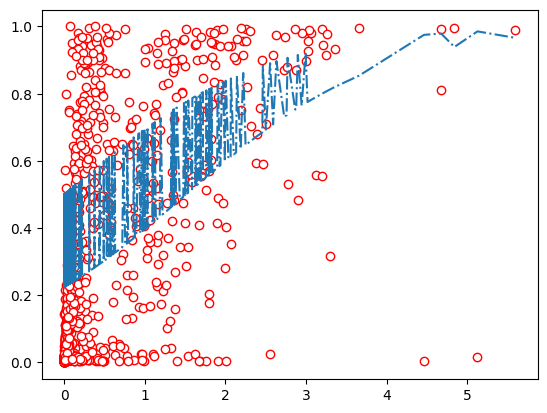

In [38]:
b = np.array(res.x[0 : X.shape[1]])  # optimal regression parameters
y_ = expit(np.dot(X, b))  # predictions

pred_df = pd.DataFrame(X, columns=["firing_rate", "synapse_class"])
pred_df["prediction"] = y_
sorted_pred_df = pred_df.sort_values(by="firing_rate")
X2 = sorted_pred_df[["firing_rate", "synapse_class"]].values
y2_ = sorted_pred_df["prediction"].values

plt.plot(X2[:, 0], y2_, "-.", zorder=1000)
plt.plot(X[:, 0], y, "ro", markerfacecolor="w")

In [39]:
b

array([ 0.82155691, -1.24154598])